<h1><font color='Teal'>Identifying Best Venue Location in San Francisco:</font></h1> 
<img src = "SF.jpg">
<h1> Introduction: </h1>
<body>
San Francisco has been dubbed the center of bohemianism. With writers such as Mark Twain and Jack London and other poets in 1950s making their best work. Then in the 1980s, a tech boom emerged in Silicon Valley allowing for transformative growth. Due to this, there have been more people moving into San Francisco with different backgrounds. The focus of the this report will be on small foodie businesses, with the intent to find the best location for a food business. 

FourSquare API allows a developer find the nearby venues to a pair of certain coordinates that you declare. In that, to find the best location to yield the most revenue, we will analyze the venues in San Francisco with the highest ratings. The following methods used will include k-means clustering. 

Objective of the analysis is to find the best venue location for an upcoming entrepreneur who is looking for the best yields. </body>

<h1>Data:</h1>

Based on the nature of the problem, there are many variables that will influence our decision, such as: 
* Number of existing restaurants in the specific neighborhoods
* Ratings of the restaurant
Each neighborhood will act as a center to find the nearest restaurants near that particular neighborhood. 

The following data sources that will need to be extracted/generated will be:
* the Latitude and Longitude of each neighborhood will be obtained using **Google Maps API geocodings**
* Number of restaurants, ratings, and category will be obtained using **FourSquare API**

In [149]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from urllib.request import urlopen 
import folium
import requests
import geocoder 
import json
from geopy.geocoders import Nominatim#converts an address into latitude and longitude
from sklearn.cluster import KMeans

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# from IPython.display import Image 
# from IPython.core.display import HTML 
# from IPython.display import display_html

<h2> Collecting Data:</h2>

In [150]:
with open('SF_data.geojson') as json_data:
    SF_data = json.load(json_data)

In [151]:
#SF_data

In [152]:
SF_Neighborhoods = SF_data['features']

Taking a look at the first index of the dict

In [153]:
SF_Neighborhoods[0]

{'type': 'Feature',
 'properties': {'link': 'http://en.wikipedia.org/wiki/Sea_Cliff,_San_Francisco,_California',
  'name': 'Seacliff'},
 'geometry': {'type': 'MultiPolygon',
  'coordinates': [[[[-122.49345526799993, 37.78351817100008],
     [-122.49372649999992, 37.78724665100009],
     [-122.49358666699993, 37.78731259500006],
     [-122.49360569399994, 37.78752774600008],
     [-122.49283007399993, 37.787882585000034],
     [-122.4927566799999, 37.78773917700005],
     [-122.48982906399993, 37.789482184000065],
     [-122.48899105699991, 37.78928318700008],
     [-122.4878640209999, 37.78958817900008],
     [-122.48736904899994, 37.78942984100007],
     [-122.48598032899991, 37.79080370600008],
     [-122.48581537399991, 37.79070384600004],
     [-122.48557750799989, 37.790559847000054],
     [-122.4850531269999, 37.79036813300007],
     [-122.4842660519999, 37.789411709000035],
     [-122.48407706799992, 37.78939909400009],
     [-122.4838230019999, 37.78928250300004],
     [-122.48

Extracting the first neighborhood name from dataframe

In [154]:
SF_Neighborhoods[0]['properties']['name']

'Seacliff'

<b>Transform the json dict into a <i>pandas</i> dataframe</b><br>
First, we need to create an empty pandas dataframe 

In [155]:
#Creating a list of names 
column_names = ['Neighborhood', 'Latitude', 'Longitude']

#Initialize the pandas dataframe
Neighborhoods = pd.DataFrame(columns = column_names)

In [156]:
for data in SF_Neighborhoods:
    Neigh_name = data['properties']['name']
    Neigh_latlon = data['geometry']['coordinates']
    latitude = Neigh_latlon[0][0][0][0]
    longitude = Neigh_latlon[0][0][0][1]
    Neighborhoods = Neighborhoods.append({'Neighborhood':Neigh_name, 
                                   'Longitude':latitude, 
                                   'Latitude':longitude},ignore_index = True)

In [157]:
Neighborhoods.head()

,Neighborhood,Latitude,Longitude
0,Seacliff,37.783518,-122.493455
1,Lake Street,37.783785,-122.487151
2,Presidio National Park,37.810993,-122.477580
3,Presidio Terrace,37.787347,-122.472411
4,Inner Richmond,37.786315,-122.472626


In [158]:
print('There are {} neighborhoods'.format(len(Neighborhoods)))

There are 117 neighborhoods


<h4>Use the Geopy library to get latitude and longitude</h4> 
In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>sf_explorer</em>, as shown below.



###### The geographical coordinates of San Francisco are 37.7749, -122.4194 

In [159]:
latitude = 37.7749 
longitude = -122.4194

<h4>Visualizing San Francisco on the map with Neighborhood names imposed on top</h4>

In [160]:
# create map of New York using latitude and longitude values
map_SF = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, neighborhood in zip(Neighborhoods['Latitude'], Neighborhoods['Longitude'], Neighborhoods['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_SF)  
    
map_SF

#### Define Foursquare Credentials and Version

In [161]:
CLIENT_ID = '3PHPL1LNPWCN4TKCCFJRJC4IYCAULMBAT1TYWW312F3PFZTH' # your Foursquare ID
CLIENT_SECRET = 'V3Q32WCU3KLJJAYWPYRUUCIUEKMKWLHRQKZRKCDBLUT5QKR0' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 3PHPL1LNPWCN4TKCCFJRJC4IYCAULMBAT1TYWW312F3PFZTH
CLIENT_SECRET:V3Q32WCU3KLJJAYWPYRUUCIUEKMKWLHRQKZRKCDBLUT5QKR0


Getting the top 3 venues in each neighborhood for a total return of 351 Venues across San Francisco:<br>
We will need to store the 3 venues to each neighborhood in a new Pandas Dataframe

In [162]:
column_names = ['Neighborhood', 'FourSquare Data']
FSqr_data = pd.DataFrame(columns = column_names)

In [163]:
LIMIT = 3 #limit of number of venues returned by Foursquare API 
sortByPopularity = 1
radius = 8000 #finding venues within 5 miles(8,000 meters) of the neighborhood  
search_query = 'Restaurant'

<b>Saving the FourSquare Api Call using pandas dataframe <i>"to_pickle"</i> function</b>

In [164]:
#FSqr_data.to_pickle('FourSquareData')

<b>Reading in the Data using <i>"pd.read_pickle"</i> function</b>

In [165]:
FSqr_data = pd.read_pickle('FourSquareData')

Lets take a look at the first index 

In [166]:
FSqr_data.head()

,Neighborhood,FourSquare Data
0,Seacliff,"{'meta': {'code': 200, 'requestId': '5fbdba4a0..."
1,Lake Street,"{'meta': {'code': 200, 'requestId': '5fbdba4be..."
2,Presidio National Park,"{'meta': {'code': 200, 'requestId': '5fbdba4b9..."
3,Presidio Terrace,"{'meta': {'code': 200, 'requestId': '5fbdba4c6..."
4,Inner Richmond,"{'meta': {'code': 200, 'requestId': '5fbdba4c4..."


Creating a new dataframe to include the venue names

## Add in the venue category column and ratings

In [167]:
column_venuedf = ['Neighborhood', 'Venue Name', 'Category']
venue_df = pd.DataFrame(columns = column_venuedf)

##### Cleaning up the data and Building a 'Venue' DataFrame. There are certain rows where the category of the resturant is not displayed, in that we will append a 'None' as a substitute

In [168]:
for i in range(len(FSqr_data)):
    for j in range(LIMIT):
        try:
            venue_df = venue_df.append({'Neighborhood': FSqr_data['Neighborhood'][i],
                    'Venue Name': FSqr_data['FourSquare Data'][i]['response']['venues'][j]['name'], 
                                       'Category':FSqr_data['FourSquare Data'][i]['response']['venues'][j]['categories'][0]['name']},
                        ignore_index = True)
        except:
             venue_df = venue_df.append({'Neighborhood': FSqr_data['Neighborhood'][i],
                    'Venue Name': FSqr_data['FourSquare Data'][i]['response']['venues'][j]['name'], 
                                       'Category':'None'},
                        ignore_index = True)

Taake a look at the first 5 indices

In [169]:
venue_df.head(12)

,Neighborhood,Venue Name,Category
0,Seacliff,Kufu-ya Japanese Restaurant,Japanese Restaurant
1,Seacliff,Kim Son Restaurant,Vietnamese Restaurant
2,Seacliff,Tommy's Mexican Restaurant,Mexican Restaurant
3,Lake Street,Kufu-ya Japanese Restaurant,Japanese Restaurant
4,Lake Street,Tommy's Mexican Restaurant,Mexican Restaurant
5,Lake Street,Kirin Chinese Restaurant,Chinese Restaurant
6,Presidio National Park,Kufu-ya Japanese Restaurant,Japanese Restaurant
7,Presidio National Park,Kamei Restaurant Supply,Food & Drink Shop
8,Presidio National Park,Taiwan Restaurant 台灣飯店,Chinese Restaurant
9,Presidio Terrace,Kamei Restaurant Supply,Food & Drink Shop


<h2> Calling FourSquare API to return Ratings for each venue </h2> 

In [170]:
id_columns = ['Venue Name', 'Venue Id']
id_df = pd.DataFrame(columns = id_columns)

In [171]:
for i in range(len(FSqr_data)):
    for j in range(LIMIT):
        try:
            id_df = id_df.append({'Venue Name': FSqr_data['FourSquare Data'][i]['response']['venues'][j]['name'],
                                  'Venue Id': FSqr_data['FourSquare Data'][i]['response']['venues'][j]['id']},
                                      ignore_index = True)
        except:
            id_df = id_df.append({'Venue Name': FSqr_data['FourSquare Data'][i]['response']['venues'][j]['name'],
                                  'Venue Id': 'None'},ignore_index = True)

In [172]:
pd.set_option('display.max_rows', None)
id_df.head()

,Venue Name,Venue Id
0,Kufu-ya Japanese Restaurant,4ceb52b2948f224bdf58005e
1,Kim Son Restaurant,4b070b96f964a52023f622e3
2,Tommy's Mexican Restaurant,3fd66200f964a520a3ec1ee3
3,Kufu-ya Japanese Restaurant,4ceb52b2948f224bdf58005e
4,Tommy's Mexican Restaurant,3fd66200f964a520a3ec1ee3


In [173]:
Ratings = pd.read_pickle('Venue Ratings')
Frsqr_rating50_to_100_data = pd.read_pickle('Venue Ratings Data starts_50')

In [174]:
Ratings.head()

,Venue Name,Rating
0,Kufu-ya Japanese Restaurant,8.2
1,Kim Son Restaurant,7.5
2,Tommy's Mexican Restaurant,8.1
3,Kufu-ya Japanese Restaurant,8.2
4,Tommy's Mexican Restaurant,8.1


<h4> Save the FourSquare return so we don't have to call again </h4> 

In [175]:
#Ratings.to_pickle('Venue Ratings')
#Frsqr_rating50_to_100_data.to_pickle('Venue Ratings Data starts_50')

<b> Read in the Ratings data </b>

In [176]:
Ratings = pd.read_pickle('Venue Ratings')
Frsqr_rating50_to_100_data = pd.read_pickle('Venue Ratings Data starts_50')

## Analyze by each Neighborhood

In [177]:
# one hot encoding
SanFranonehot = pd.get_dummies(Ratings[['Venue Name']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
SanFranonehot['Neighborhood'] = venue_df['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [SanFranonehot.columns[-1]] + list(SanFranonehot.columns[:-1])
SanFranonehot = SanFranonehot[fixed_columns]

In [178]:
pd.set_option('display.max_columns', None)
SanFranonehot.head()

,Neighborhood,750 Restaurant & Bar,8 Immortals Restaurant,Akiko’s Restaurant & Sushi Bar,Alice's Restaurant,Basil Thai Restaurant & Bar,Beach Chalet Brewery & Restaurant,Beijing Restaurant 北京小馆,Big 4 Restaurant,Bonanza Restaurant,Brother's Korean Restaurant,Bullshead Restaurant,Chavita's Restaurant,Clay Oven Indian Restaurant,Darbar Restaurant,Delancey Street Restaurant,Don Ramon's Mexican Restaurant,El Porteño Restaurant,Eliza's Restaurant,Elsy's Restaurant,Emmy's Chinese Restaurant,Evergreen Garden Restaurant,Franciscan Crab Restaurant,G&L Bakery and Restaurant 大新茶餐廳,Golden China Restaurant 永華(金華)飯店,Harbor Villa Restaurant,Harris' Restaurant,Henry's Hunan Restaurant,Heung Yuen Restaurant,Hong Kong B.B.Q. Restaurant 香港燒臘,Isa Restaurant,J A Z Restaurant Equipment,Java Indonesian Restaurant,Jitlada Thai Restaurant,Kamei Restaurant Supply,Kezar Bar & Restaurant,Kim Son Restaurant,Kirin Chinese Restaurant,Kufu-ya Japanese Restaurant,Lakeview Restaurant,Loi's Vietnamese Restaurant,Lucky Creation Restaurant,Maple Restaurant,Mars Bar & Restaurant,May Lee Restaurant,Ming Kee Restaurant 明記燒臘茶餐廳,Nena's Restaurant,New Cheung Hing Restaurant,New Eritrea Restaurant & Bar,New Imperial Garden Seafood Restaurant 新德群海鮮酒家,New Tsing Tao Restaurant,New Woey Loy Goey Restaurant,North Beach Restaurant,Old Mandarin Islamic Restaurant 老北京,One Market Restaurant,Osha Thai Restaurant & Lounge,Pa'ina Lounge & Restaurant,Panchita's Pupuseria Restaurant #2,Pier Market Seafood Restaurant,Reina's Restaurant,Restaurant Anzu,Restaurant Depot,Restaurant Pupuseria Ilobasco,Ryoko's Japanese Restaurant & Bar,Sai's Vietnamese Restaurant,Sally's Restaurant & Deli,Sam's Grill & Seafood Restaurant,San Tung Chinese Restaurant 山東小館 (San Tung Chinese Restaurant),San Vicente Restaurant,San Wang Restaurant,Scoma's Restaurant,Sun Jin's Cafe Restaurant,Sun Rise Restaurant,Super Star Restaurant,Taiwan Restaurant 台灣飯店,Tanuki Restaurant 狸壽司,Tarantino's Restaurant,The Chieftain Irish Pub & Restaurant,The Matterhorn Swiss Restaurant,Tommy's Mexican Restaurant,Tony's Cable Car Restaurant,Town's End Restaurant & Bakery,Trimark Economy Restaurant Fixtures,Tuba - Authentic Turkish Restaurant,Tú Lan Restaurant,Waterfront Restaurant,Win Fook Chinese Restaurant,Yemeni's Restaurant,Z & Y Restaurant
0,Seacliff,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Seacliff,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Seacliff,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,Lake Street,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Lake Street,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


###### Determining the Frequency of a Restaurant at each neighborhood

In [179]:
SanFran_grouped = SanFranonehot.groupby('Neighborhood').mean().reset_index()

In [180]:
SanFran_grouped.shape

(117, 89)

###### Finding the top 5 venues

In [181]:
num_top_venues = 5
for hood in SanFran_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = SanFran_grouped[SanFran_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Alamo Square----
                         venue  freq
0      Jitlada Thai Restaurant  0.33
1          San Wang Restaurant  0.33
2   Pa'ina Lounge & Restaurant  0.33
3         750 Restaurant & Bar  0.00
4  Sai's Vietnamese Restaurant  0.00


----Anza Vista----
                                venue  freq
0          Pa'ina Lounge & Restaurant  0.33
1                  Eliza's Restaurant  0.33
2         Tony's Cable Car Restaurant  0.33
3  Panchita's Pupuseria Restaurant #2  0.00
4           Sally's Restaurant & Deli  0.00


----Apparel City----
                            venue  freq
0              Alice's Restaurant  0.33
1               Elsy's Restaurant  0.33
2            Chavita's Restaurant  0.33
3            750 Restaurant & Bar  0.00
4  Pier Market Seafood Restaurant  0.00


----Aquatic Park / Ft. Mason----
                                venue  freq
0     The Matterhorn Swiss Restaurant  0.33
1          Franciscan Crab Restaurant  0.33
2                  Scoma's Restaurant  0.3

4  Sam's Grill & Seafood Restaurant  0.00


----Inner Richmond----
                         venue  freq
0       Taiwan Restaurant 台灣飯店  0.33
1        Tanuki Restaurant 狸壽司  0.33
2      Kamei Restaurant Supply  0.17
3  Brother's Korean Restaurant  0.17
4         750 Restaurant & Bar  0.00


----Inner Sunset----
                                               venue  freq
0  San Tung Chinese Restaurant 山東小館 (San Tung Chi...  0.33
1                        Loi's Vietnamese Restaurant  0.33
2                         New Cheung Hing Restaurant  0.33
3                        Win Fook Chinese Restaurant  0.00
4                          Sally's Restaurant & Deli  0.00


----Japantown----
                         venue  freq
0      Jitlada Thai Restaurant  0.33
1          San Wang Restaurant  0.33
2   Pa'ina Lounge & Restaurant  0.33
3         750 Restaurant & Bar  0.00
4  Sai's Vietnamese Restaurant  0.00


----Laguna Honda----
                                               venue  freq
0         

4   Pa'ina Lounge & Restaurant  0.00


----Silver Terrace----
                                            venue  freq
0  New Imperial Garden Seafood Restaurant 新德群海鮮酒家  0.33
1                   Restaurant Pupuseria Ilobasco  0.33
2                Hong Kong B.B.Q. Restaurant 香港燒臘  0.33
3                            750 Restaurant & Bar  0.00
4                  Pier Market Seafood Restaurant  0.00


----South Beach----
                            venue  freq
0  Town's End Restaurant & Bakery  0.33
1   Osha Thai Restaurant & Lounge  0.33
2      Delancey Street Restaurant  0.33
3            750 Restaurant & Bar  0.00
4  Pier Market Seafood Restaurant  0.00


----South of Market----
                            venue  freq
0           One Market Restaurant  0.33
1   Osha Thai Restaurant & Lounge  0.33
2      Delancey Street Restaurant  0.33
3            750 Restaurant & Bar  0.00
4  Pier Market Seafood Restaurant  0.00


----St. Francis Wood----
                                venue  freq
0  

In [182]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [183]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
SanFran_venues_sorted = pd.DataFrame(columns=columns)
SanFran_venues_sorted['Neighborhood'] = SanFran_grouped['Neighborhood']

for ind in np.arange(SanFran_grouped.shape[0]):
    SanFran_venues_sorted.iloc[ind, 1:] = return_most_common_venues(SanFran_grouped.iloc[ind, :], num_top_venues)


SanFran_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alamo Square,San Wang Restaurant,Jitlada Thai Restaurant,Pa'ina Lounge & Restaurant,Z & Y Restaurant,J A Z Restaurant Equipment,Golden China Restaurant 永華(金華)飯店,Harbor Villa Restaurant,Harris' Restaurant,Henry's Hunan Restaurant,Heung Yuen Restaurant
1,Anza Vista,Eliza's Restaurant,Tony's Cable Car Restaurant,Pa'ina Lounge & Restaurant,Z & Y Restaurant,Java Indonesian Restaurant,Harbor Villa Restaurant,Harris' Restaurant,Henry's Hunan Restaurant,Heung Yuen Restaurant,Hong Kong B.B.Q. Restaurant 香港燒臘
2,Apparel City,Chavita's Restaurant,Alice's Restaurant,Elsy's Restaurant,Z & Y Restaurant,Harris' Restaurant,Henry's Hunan Restaurant,Heung Yuen Restaurant,Hong Kong B.B.Q. Restaurant 香港燒臘,Isa Restaurant,J A Z Restaurant Equipment
3,Aquatic Park / Ft. Mason,Scoma's Restaurant,The Matterhorn Swiss Restaurant,Franciscan Crab Restaurant,Z & Y Restaurant,J A Z Restaurant Equipment,Golden China Restaurant 永華(金華)飯店,Harbor Villa Restaurant,Harris' Restaurant,Henry's Hunan Restaurant,Heung Yuen Restaurant
4,Ashbury Heights,May Lee Restaurant,Kezar Bar & Restaurant,San Tung Chinese Restaurant 山東小館 (San Tung Chi...,Loi's Vietnamese Restaurant,Isa Restaurant,G&L Bakery and Restaurant 大新茶餐廳,Golden China Restaurant 永華(金華)飯店,Harbor Villa Restaurant,Harris' Restaurant,Henry's Hunan Restaurant


In [184]:
NeighVenue = venue_df
NeighVenue['Rating'] = Ratings['Rating']
for i in range(len(NeighVenue)):
    if NeighVenue['Rating'][i] == 'None':
        NeighVenue['Rating'][i] = 0

In [197]:
RatingSort = NeighVenue.sort_values('Rating', ascending = False).reset_index()
RatingSort.head(5)

,index,Neighborhood,Venue Name,Category,Rating
0,145,Golden Gate Heights,New Eritrea Restaurant & Bar,Ethiopian Restaurant,9.1
1,23,Presidio National Park,Brother's Korean Restaurant,Korean Restaurant,8.8
2,85,Panhandle,Brother's Korean Restaurant,Korean Restaurant,8.8
3,44,Presidio Heights,Brother's Korean Restaurant,Korean Restaurant,8.8
4,176,Potrero Hill,Panchita's Pupuseria Restaurant #2,Latin American Restaurant,8.8


###### Finding the mean, std, max and the different quartile values of 'Rating' column

In [212]:
print('Mean =',Rating_2['Rating'].mean())
print('Max =',Rating_2['Rating'].max())
print('Std =',Rating_2['Rating'].std())
print(Rating_2['Rating'].quantile([.25,.5,.75,.95]))

Mean = 6.590710382513657
Max = 9.1
Std = 2.453350192126468
0.25    6.525
0.50      7.3
0.75      8.1
0.95      8.7
Name: Rating, dtype: object


Text(0.5, 1.0, 'Category Freq Rating > 8')

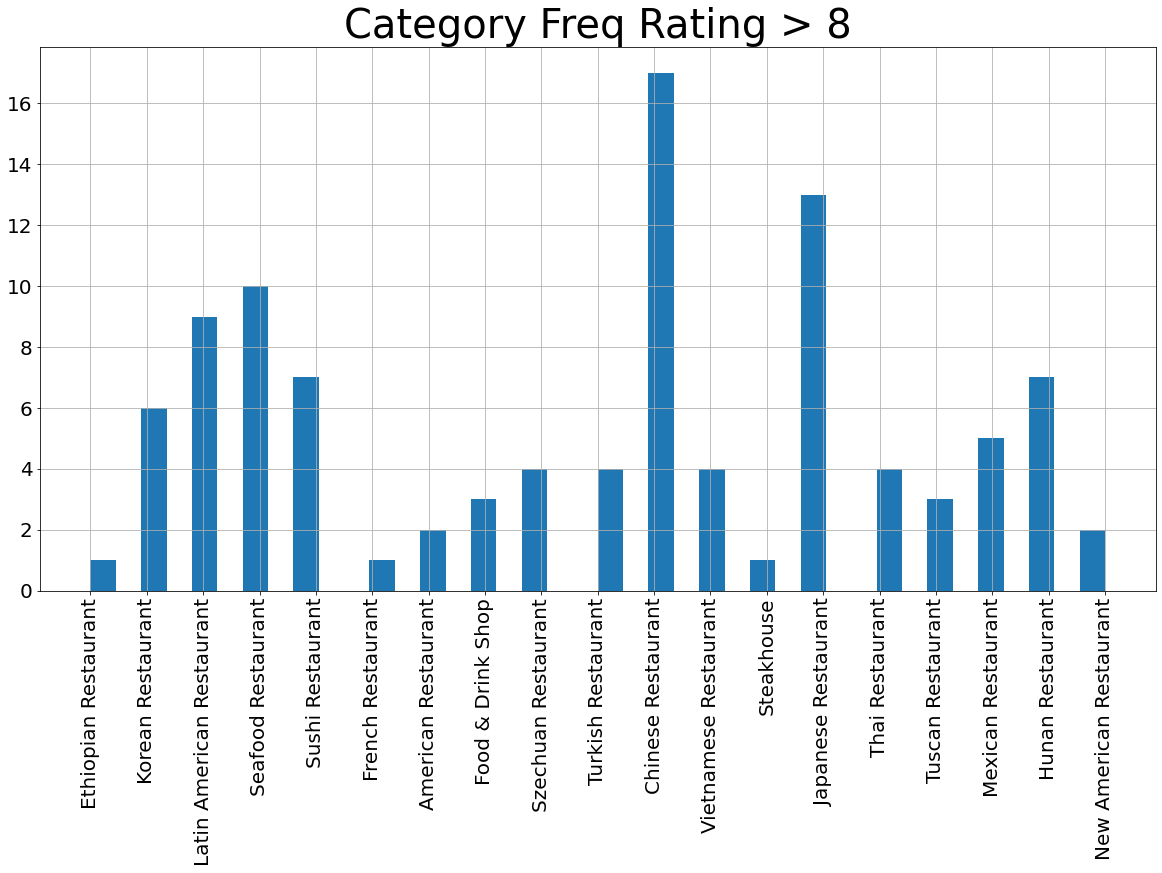

In [187]:
Rating3 = Rating_2[0:103]
Rating3['Category'].hist(bins = 40,
                         figsize = (20,10), 
                         xrot = 90,
                         xlabelsize= 20,ylabelsize =20)
plt.title('Category Freq Rating > 8', size = 40)


Text(0.5, 1.0, 'Neighborhood Freq Rating > 8')

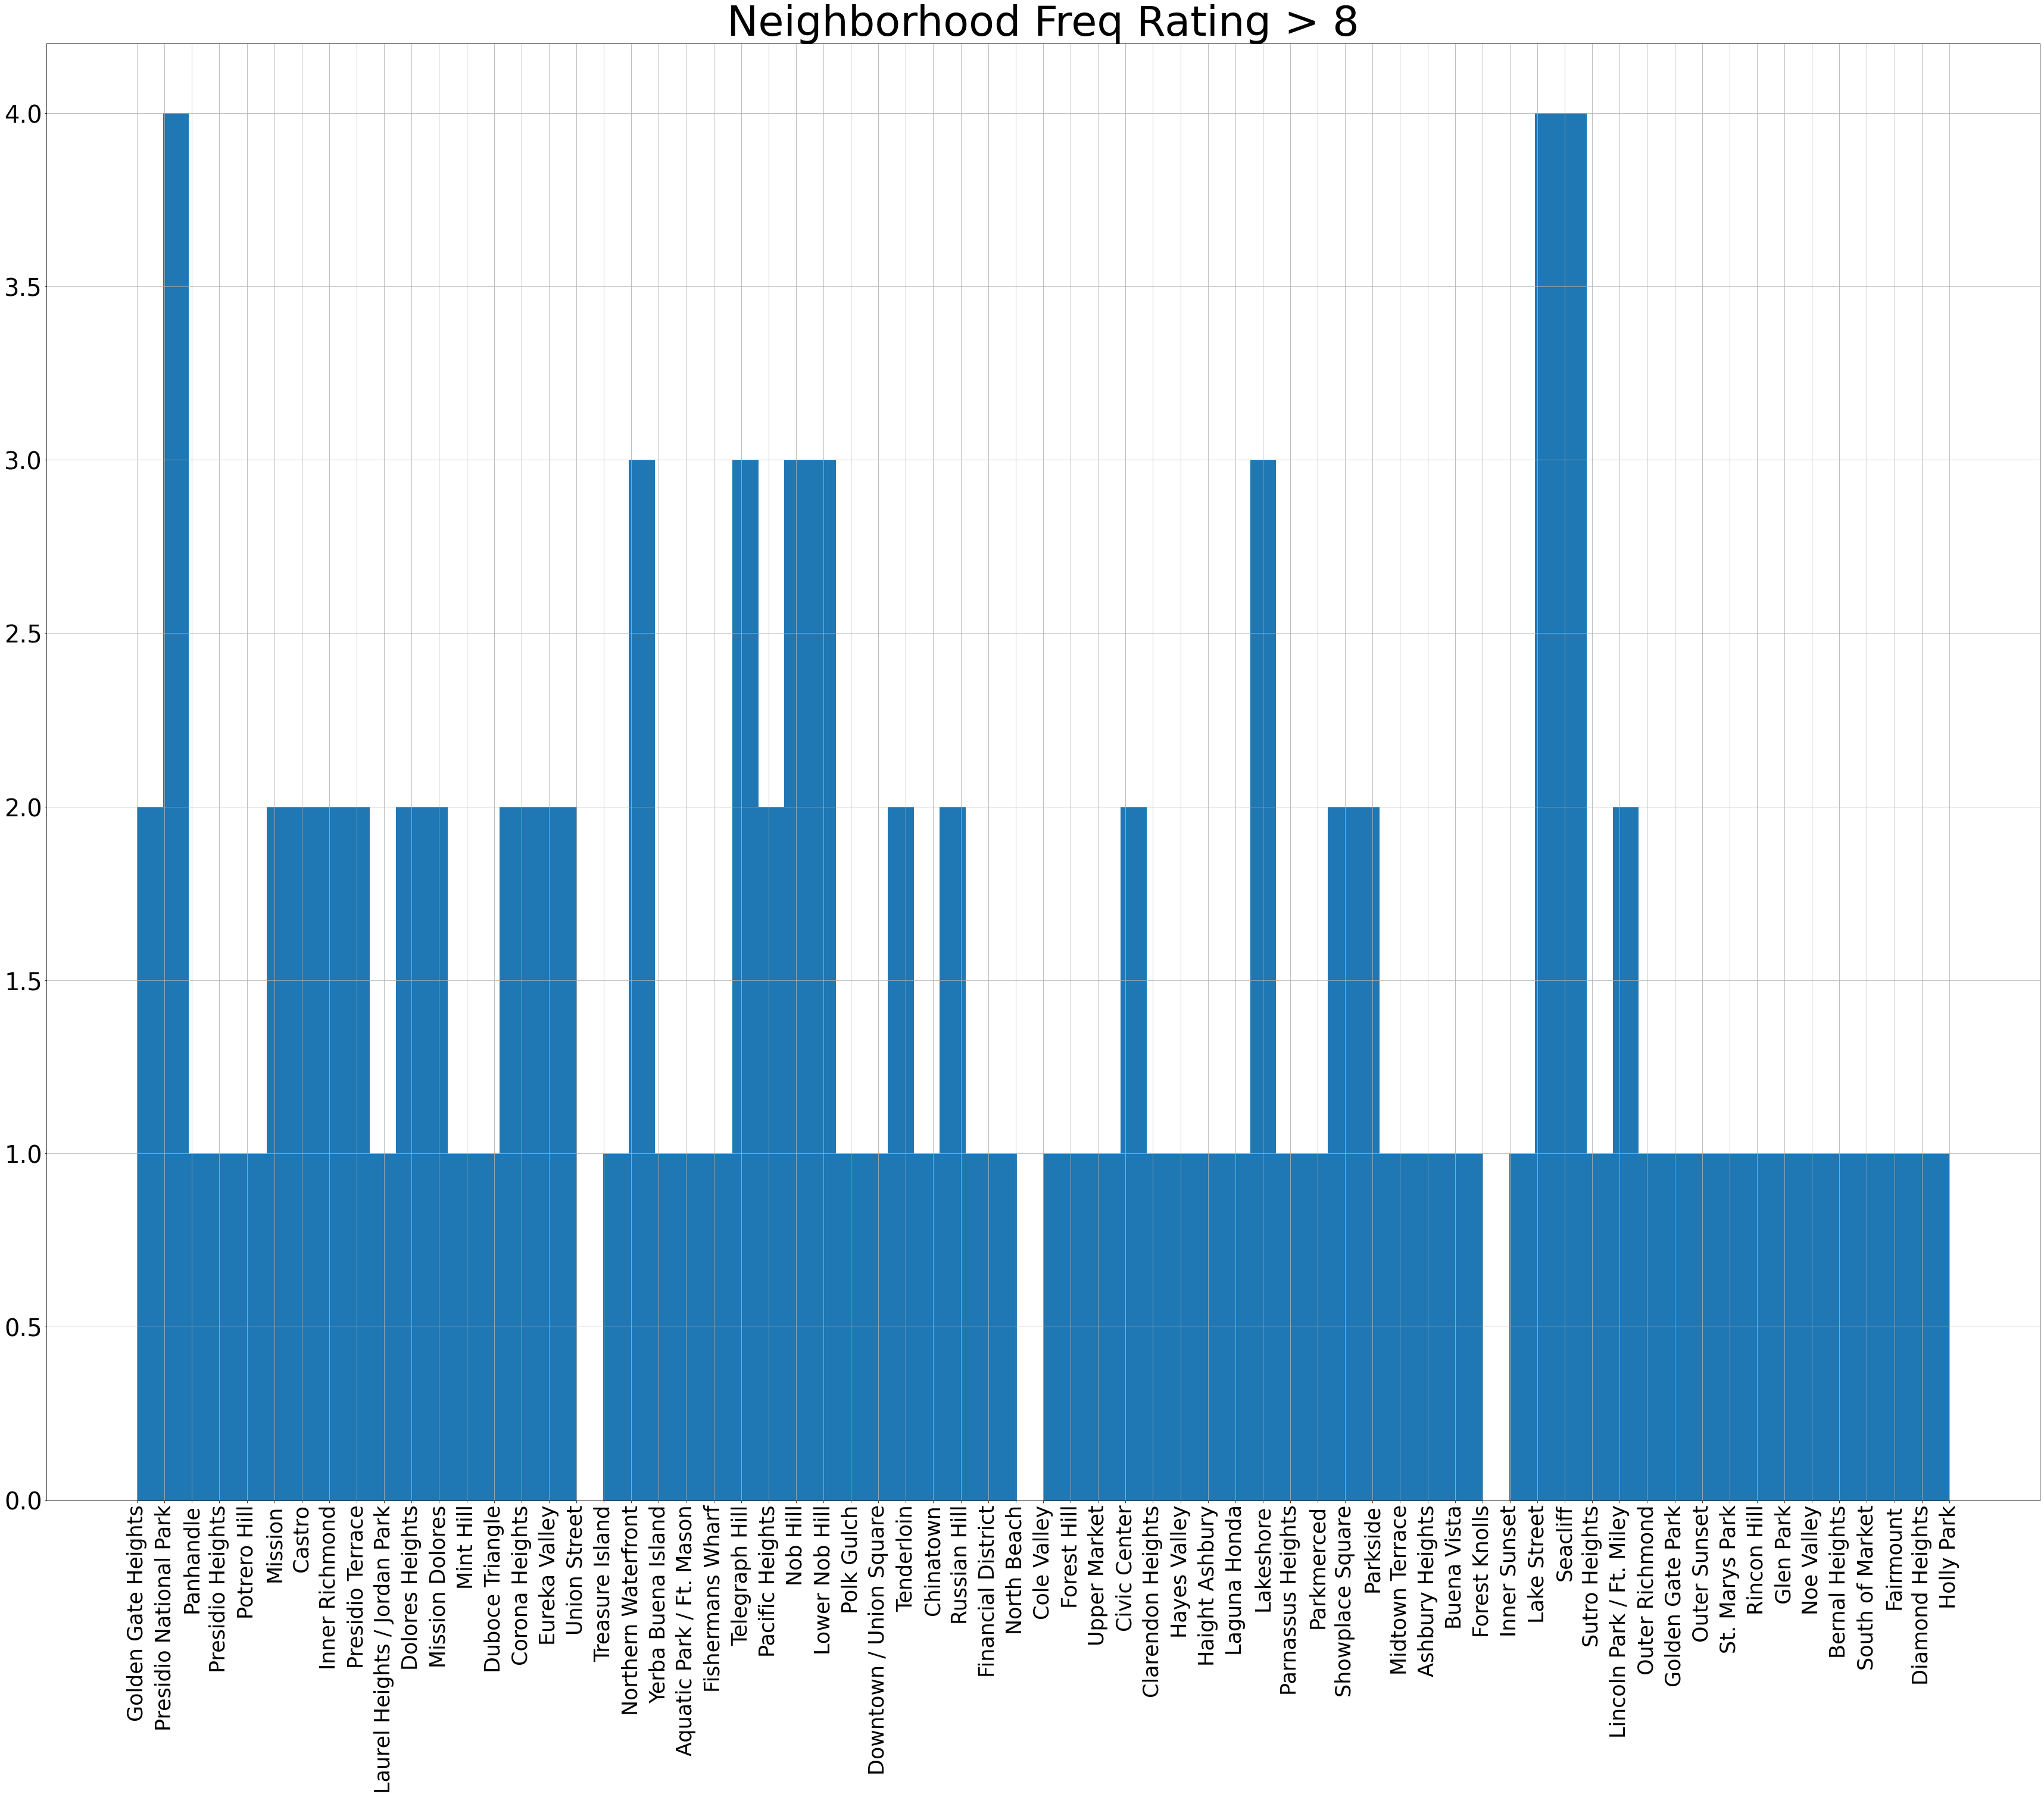

In [188]:
Rating3 = Rating_2[0:103]
Rating3['Neighborhood'].hist(bins = 70,
                         figsize = (60,45), 
                         xrot = 90,
                         xlabelsize= 35,ylabelsize =40)
plt.title('Neighborhood Freq Rating > 8', size = 70)



# Clusterting Neighborhoods 

In [189]:
SanFran_clustering = SanFran_grouped.drop('Neighborhood',1)
SanFran_clustering.head(1)

,750 Restaurant & Bar,8 Immortals Restaurant,Akiko’s Restaurant & Sushi Bar,Alice's Restaurant,Basil Thai Restaurant & Bar,Beach Chalet Brewery & Restaurant,Beijing Restaurant 北京小馆,Big 4 Restaurant,Bonanza Restaurant,Brother's Korean Restaurant,Bullshead Restaurant,Chavita's Restaurant,Clay Oven Indian Restaurant,Darbar Restaurant,Delancey Street Restaurant,Don Ramon's Mexican Restaurant,El Porteño Restaurant,Eliza's Restaurant,Elsy's Restaurant,Emmy's Chinese Restaurant,Evergreen Garden Restaurant,Franciscan Crab Restaurant,G&L Bakery and Restaurant 大新茶餐廳,Golden China Restaurant 永華(金華)飯店,Harbor Villa Restaurant,Harris' Restaurant,Henry's Hunan Restaurant,Heung Yuen Restaurant,Hong Kong B.B.Q. Restaurant 香港燒臘,Isa Restaurant,J A Z Restaurant Equipment,Java Indonesian Restaurant,Jitlada Thai Restaurant,Kamei Restaurant Supply,Kezar Bar & Restaurant,Kim Son Restaurant,Kirin Chinese Restaurant,Kufu-ya Japanese Restaurant,Lakeview Restaurant,Loi's Vietnamese Restaurant,Lucky Creation Restaurant,Maple Restaurant,Mars Bar & Restaurant,May Lee Restaurant,Ming Kee Restaurant 明記燒臘茶餐廳,Nena's Restaurant,New Cheung Hing Restaurant,New Eritrea Restaurant & Bar,New Imperial Garden Seafood Restaurant 新德群海鮮酒家,New Tsing Tao Restaurant,New Woey Loy Goey Restaurant,North Beach Restaurant,Old Mandarin Islamic Restaurant 老北京,One Market Restaurant,Osha Thai Restaurant & Lounge,Pa'ina Lounge & Restaurant,Panchita's Pupuseria Restaurant #2,Pier Market Seafood Restaurant,Reina's Restaurant,Restaurant Anzu,Restaurant Depot,Restaurant Pupuseria Ilobasco,Ryoko's Japanese Restaurant & Bar,Sai's Vietnamese Restaurant,Sally's Restaurant & Deli,Sam's Grill & Seafood Restaurant,San Tung Chinese Restaurant 山東小館 (San Tung Chinese Restaurant),San Vicente Restaurant,San Wang Restaurant,Scoma's Restaurant,Sun Jin's Cafe Restaurant,Sun Rise Restaurant,Super Star Restaurant,Taiwan Restaurant 台灣飯店,Tanuki Restaurant 狸壽司,Tarantino's Restaurant,The Chieftain Irish Pub & Restaurant,The Matterhorn Swiss Restaurant,Tommy's Mexican Restaurant,Tony's Cable Car Restaurant,Town's End Restaurant & Bakery,Trimark Economy Restaurant Fixtures,Tuba - Authentic Turkish Restaurant,Tú Lan Restaurant,Waterfront Restaurant,Win Fook Chinese Restaurant,Yemeni's Restaurant,Z & Y Restaurant
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [200]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(SanFran_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 1, 0, 0, 2, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 2, 2, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 1, 0, 0, 0, 0, 0,
       0, 2, 1, 2, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 2, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 1, 0, 0, 0], dtype=int32)

In [207]:
#Dropping the 'Cluster Labels' if it exists, otherwise it adds it the dataframe
try:
    SanFran_venues_sorted = SanFran_venues_sorted.drop('Cluster Labels', 1)
except:
    SanFran_venues_sorted.insert(0,'Cluster Labels', kmeans.labels_)

In [208]:
SanFran_merged = Neighborhoods

SanFran_merged = SanFran_merged.join(SanFran_venues_sorted.set_index('Neighborhood'), on = 'Neighborhood')
SanFran_merged.head(1)

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Seacliff,37.783518,-122.493455,0,Kufu-ya Japanese Restaurant,Kim Son Restaurant,Tommy's Mexican Restaurant,Z & Y Restaurant,J A Z Restaurant Equipment,Golden China Restaurant 永華(金華)飯店,Harbor Villa Restaurant,Harris' Restaurant,Henry's Hunan Restaurant,Heung Yuen Restaurant


In [209]:
SanFran_merged.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Seacliff,37.783518,-122.493455,0,Kufu-ya Japanese Restaurant,Kim Son Restaurant,Tommy's Mexican Restaurant,Z & Y Restaurant,J A Z Restaurant Equipment,Golden China Restaurant 永華(金華)飯店,Harbor Villa Restaurant,Harris' Restaurant,Henry's Hunan Restaurant,Heung Yuen Restaurant
1,Lake Street,37.783785,-122.487151,0,Kufu-ya Japanese Restaurant,Kirin Chinese Restaurant,Tommy's Mexican Restaurant,Z & Y Restaurant,J A Z Restaurant Equipment,Golden China Restaurant 永華(金華)飯店,Harbor Villa Restaurant,Harris' Restaurant,Henry's Hunan Restaurant,Heung Yuen Restaurant
2,Presidio National Park,37.810993,-122.477580,0,Kufu-ya Japanese Restaurant,Taiwan Restaurant 台灣飯店,Kamei Restaurant Supply,Brother's Korean Restaurant,Tanuki Restaurant 狸壽司,Z & Y Restaurant,Golden China Restaurant 永華(金華)飯店,Harbor Villa Restaurant,Harris' Restaurant,Henry's Hunan Restaurant
3,Presidio Terrace,37.787347,-122.472411,0,Tanuki Restaurant 狸壽司,Taiwan Restaurant 台灣飯店,Kamei Restaurant Supply,Brother's Korean Restaurant,Z & Y Restaurant,Golden China Restaurant 永華(金華)飯店,Harbor Villa Restaurant,Harris' Restaurant,Henry's Hunan Restaurant,Heung Yuen Restaurant
4,Inner Richmond,37.786315,-122.472626,0,Tanuki Restaurant 狸壽司,Taiwan Restaurant 台灣飯店,Kamei Restaurant Supply,Brother's Korean Restaurant,Z & Y Restaurant,Golden China Restaurant 永華(金華)飯店,Harbor Villa Restaurant,Harris' Restaurant,Henry's Hunan Restaurant,Heung Yuen Restaurant


In [211]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, VN, cluster, i in zip(SanFran_merged['Latitude'], SanFran_merged['Longitude'], SanFran_merged['Neighborhood'], RatingSort['Venue Name'], SanFran_merged['Cluster Labels'], range(len(SanFran_merged))):
    label = folium.Popup('Neighborhood:\n'+ str(poi)+ '\nRestuarant Name:\n' + '\n' + str(VN) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Lets take a look at the top 5 venues with the Highest Ratings

In [205]:
Top5Venues = {'Neighborhood':[RatingSort.iloc[0,1],RatingSort.iloc[1,1],RatingSort.iloc[4,1],RatingSort.iloc[16,1],RatingSort.iloc[24,1],RatingSort.iloc[25,1]], 
              'Latitude':[Neighborhoods.iloc[43,1],Neighborhoods.iloc[2,1],Neighborhoods.iloc[53,1],Neighborhoods.iloc[14,1],Neighborhoods.iloc[15,1],Neighborhoods.iloc[49,1]],
              'Longitude':[Neighborhoods.iloc[43,2],Neighborhoods.iloc[2,2],Neighborhoods.iloc[53,2],Neighborhoods.iloc[14,2],Neighborhoods.iloc[15,2],Neighborhoods.iloc[49,2]],
              'Venue':[RatingSort.iloc[0,2],RatingSort.iloc[1,2],RatingSort.iloc[4,2],RatingSort.iloc[16,2],RatingSort.iloc[24,2],RatingSort.iloc[25,2]], 
              'Category':[RatingSort.iloc[0,3],RatingSort.iloc[1,3],RatingSort.iloc[4,3],RatingSort.iloc[16,3],RatingSort.iloc[24,3],RatingSort.iloc[25,3]], 
              'Rating':[RatingSort.iloc[0,4],RatingSort.iloc[1,4],RatingSort.iloc[4,4],RatingSort.iloc[16,4],RatingSort.iloc[24,4],RatingSort.iloc[25,4]]}
Top5Venues_df = pd.DataFrame(data = Top5Venues)

In [206]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi,cat, VN,rating in zip(Top5Venues_df['Latitude'],Top5Venues_df['Longitude'],Top5Venues_df['Neighborhood'],Top5Venues_df['Category'],Top5Venues_df['Venue'],Top5Venues_df['Rating']):
    label = folium.Popup('Neighborhood:\n'+ str(poi)+ '\nRestuarant Name:\n'  + str(VN) + '\nCategory:'+ str(cat)+'\nRating' + str(rating), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       

map_clusters